In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'end', 'start', 'bibref', 'mention', 'text', 'introduction'])

In [3]:
df = pd.read_csv('text17.txt')
df

FileNotFoundError: [Errno 2] File text17.txt does not exist: 'text17.txt'

In [62]:
df['content'] = df['content'].fillna('').apply(str)
df

,content,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 1014,Unnamed: 1015,Unnamed: 1016,Unnamed: 1017,Unnamed: 1018,Unnamed: 1019,Unnamed: 1020,Unnamed: 1021,Unnamed: 1022,Unnamed: 1023
0,"{'text': 'In 1990, 9% of the population of the United States were firstgeneration immigrants; by...",{'text': 'Despite comprising a minority (albeit a significant minority) of the population of dev...,{'text': 'There are specific health issues that are related to immigration. On arrival in their ...,{'text': 'There are few data available regarding VFRs as a specific group. One of the difficulti...,{'text': 'There has been a shift in immigration patterns from a predominance of European migrant...,{'text': 'back to these areas. These shifting trends in the travel destinations of VFRs bring wi...,{'text': 'Those who return to their country of origin to visit friends and relatives are likely ...,"{'text': 'Despite their frequency of travel, VFRs as a group are less likely to seek pretravel a...",{'text': 'Language and cultural barriers may prevent VFRs from seeking medical advice. Pretravel...,"{'text': 'Of those who did seek pretravel advice, a variety of sources were consulted, including...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"{'text': 'After the detection of the novel coronavirus disease in December 2019 in Wuhan city, H...","{'text': 'On February 12, 2020, Chen et al. [2] reported the clinical characteristics of COVID-1...",{'text': 'Epidemiological studies suggest that maternal immune activation (MIA) plays a role in ...,{'text': 'A national birth study in Finland suggested that high levels of CRP during pregnancy a...,{'text': 'There are increasing interests in the potential benefit of early intervention by safe ...,"{'text': 'Previously, we reported that dietary intake of glucoraphanin food pellet during juveni...","{'text': 'In conclusion, the number of pregnant women infected with COVID-19 is expected to incr...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,{'text': 'The risk of Middle East Respiratory Syndrome Coronavirus spreading globally is worryin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"{'text': ""A decade after SARS, another coronavirus associated with high mortality rates is the s...","{'text': 'Umrah. Understanding what the risk to pilgrims is, what the risks of pilgrims returnin...",{'text': 'The risk of infection to pilgrims coming from different regions can be estimated based...,"{'text': 'Based on the incidence in the KSA since June 2012, we estimate that the most likely sc...","{'text': 'Despite the circulation of MERS-CoV in the KSA since 2012, and conditions of overcrowd...","{'text': 'There was no need to obtain ethics committee approval.', 'cite_spans': [], 'ref_spans'...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5682,"{'text': 'The author discloses no conflicts of interest, competing interests, or potential finan...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5683,{'text': 'The novel coronavirus disease 2019 (COVID-19) pandemic has dramatically impacted the h...,{'text': 'A recent epidemiological study provided the first national assessment of the disparity...,"{'text': 'First, we categorized counties into two groups: disproportionately Latino counties (>1...",{'text': 'To assess whether the observed associations between the proportion of Latino residents...,{'text': 'Fourteen percent of U.S. counties (443/3143) are disproportionately Latino. As of May ...,{'text': 'Differences in COVID-19 cases by region are replicated in the bivariate analyses compa...,"{'text': 'In Table 2\n, the multivariate model examining predictors of both COVID-19 cases and a...","{'text'

In [63]:
# Convert to list
data = df.content.values.tolist()


# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]



pprint(data[:1])


['{text: In 1990, 9% of the population of the United States were '
 'firstgeneration immigrants; by the year 2000, this had increased to more '
 'than 12% or almost 35 million people. If one also takes into consideration '
 'the children of first-generation immigrants, they make up almost 20% of the '
 'American population. In Canada, the percentage of the population that was '
 'foreign born in 2000 was 19%. Worldwide, the number of people living outside '
 'their birth country was 175 million-more than twice the number since 1970 '
 '[1] . In cities such as Miami, Los Angeles, and Toronto, Canada, almost 50% '
 'of the population is foreign born [2] ., cite_spans: [{start: 505, end: 508, '
 'text: [1], ref_id: BIBREF0}, {start: 615, end: 618, text: [2], ref_id: '
 'None}], ref_spans: [], section: Introduction}']


In [64]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['text', 'in', 'of', 'the', 'population', 'of', 'the', 'united', 'states', 'were', 'firstgeneration', 'immigrants', 'by', 'the', 'year', 'this', 'had', 'increased', 'to', 'more', 'than', 'or', 'almost', 'million', 'people', 'if', 'one', 'also', 'takes', 'into', 'consideration', 'the', 'children', 'of', 'first', 'generation', 'immigrants', 'they', 'make', 'up', 'almost', 'of', 'the', 'american', 'population', 'in', 'canada', 'the', 'percentage', 'of', 'the', 'population', 'that', 'was', 'foreign', 'born', 'in', 'was', 'worldwide', 'the', 'number', 'of', 'people', 'living', 'outside', 'their', 'birth', 'country', 'was', 'million', 'more', 'than', 'twice', 'the', 'number', 'since', 'in', 'cities', 'such', 'as', 'miami', 'los', 'angeles', 'and', 'toronto', 'canada', 'almost', 'of', 'the', 'population', 'is', 'foreign', 'born', 'cite_spans', 'start', 'end', 'text', 'ref_id', 'bibref', 'start', 'end', 'text', 'ref_id', 'none', 'ref_spans', 'section', 'introduction']]


In [65]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['text', 'in', 'of', 'the', 'population', 'of', 'the', 'united_states', 'were', 'firstgeneration', 'immigrants', 'by', 'the', 'year', 'this', 'had', 'increased', 'to', 'more', 'than', 'or', 'almost', 'million', 'people', 'if', 'one', 'also', 'takes', 'into', 'consideration', 'the', 'children', 'of', 'first', 'generation', 'immigrants', 'they', 'make', 'up', 'almost', 'of', 'the', 'american', 'population', 'in', 'canada', 'the', 'percentage', 'of', 'the', 'population', 'that', 'was', 'foreign', 'born', 'in', 'was', 'worldwide', 'the', 'number', 'of', 'people', 'living', 'outside', 'their', 'birth', 'country', 'was', 'million', 'more', 'than', 'twice', 'the', 'number', 'since', 'in', 'cities', 'such', 'as', 'miami', 'los', 'angeles', 'and', 'toronto_canada', 'almost', 'of', 'the', 'population', 'is', 'foreign', 'born', 'cite_spans', 'start', 'end', 'text', 'ref_id', 'bibref', 'start', 'end', 'text', 'ref_id', 'none', 'ref_spans', 'section', 'introduction']


In [66]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [67]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['text', 'population', 'firstgeneration', 'immigrant', 'year', 'increase', 'almost', 'people', 'also', 'take', 'consideration', 'child', 'first', 'generation', 'immigrant', 'make', 'almost', 'american', 'population', 'foreign', 'bear', 'worldwide', 'number', 'people', 'live', 'birth', 'country', 'twice', 'number', 'city', 'almost', 'population', 'foreign', 'bear', 'start', 'end', 'text', 'bibref', 'start', 'end', 'text', 'ref_id', 'none', 'ref_span', 'section', 'introduction']]


In [68]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])



[[(0, 3), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 2), (23, 3), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 3), (30, 1), (31, 1), (32, 1)]]


In [75]:
id2word[0]

'almost'

In [76]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('almost', 3),
  ('also', 1),
  ('american', 1),
  ('bear', 2),
  ('bibref', 1),
  ('birth', 1),
  ('child', 1),
  ('city', 1),
  ('consideration', 1),
  ('country', 1),
  ('end', 2),
  ('first', 1),
  ('firstgeneration', 1),
  ('foreign', 2),
  ('generation', 1),
  ('immigrant', 2),
  ('increase', 1),
  ('introduction', 1),
  ('live', 1),
  ('make', 1),
  ('none', 1),
  ('number', 2),
  ('people', 2),
  ('population', 3),
  ('ref_id', 1),
  ('ref_span', 1),
  ('section', 1),
  ('start', 2),
  ('take', 1),
  ('text', 3),
  ('twice', 1),
  ('worldwide', 1),
  ('year', 1)]]

In [77]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [78]:
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [79]:
data_ready = data_lemmatized


def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)


In [80]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9323,"human, virus, transmission, animal, infection, pathogen, contact, specie, interest, activity","[airborne, toxic, aerosol, particle, multiple, source, various, size, composition, ventilation, ..."
1,1.0,0.9849,"risk, section, health, text, disease, pandemic, ref_span, introduction, public, country","[era, globalization, representation, infectious, disease, threat, profound, implication, underst..."
2,2.0,0.9826,"patient, infection, risk, study, section, factor, high, treatment, covid, severe","[text, background, cause, upper, low, respiratory, tract, infection, respectively, healthy, pati..."
3,3.0,0.9888,"end, start, bibref, mention, text, introduction, case, disease, section, respiratory","[text, febrile, respiratory, illness, fri, result, substantial, disease, burden, semi_close, env..."


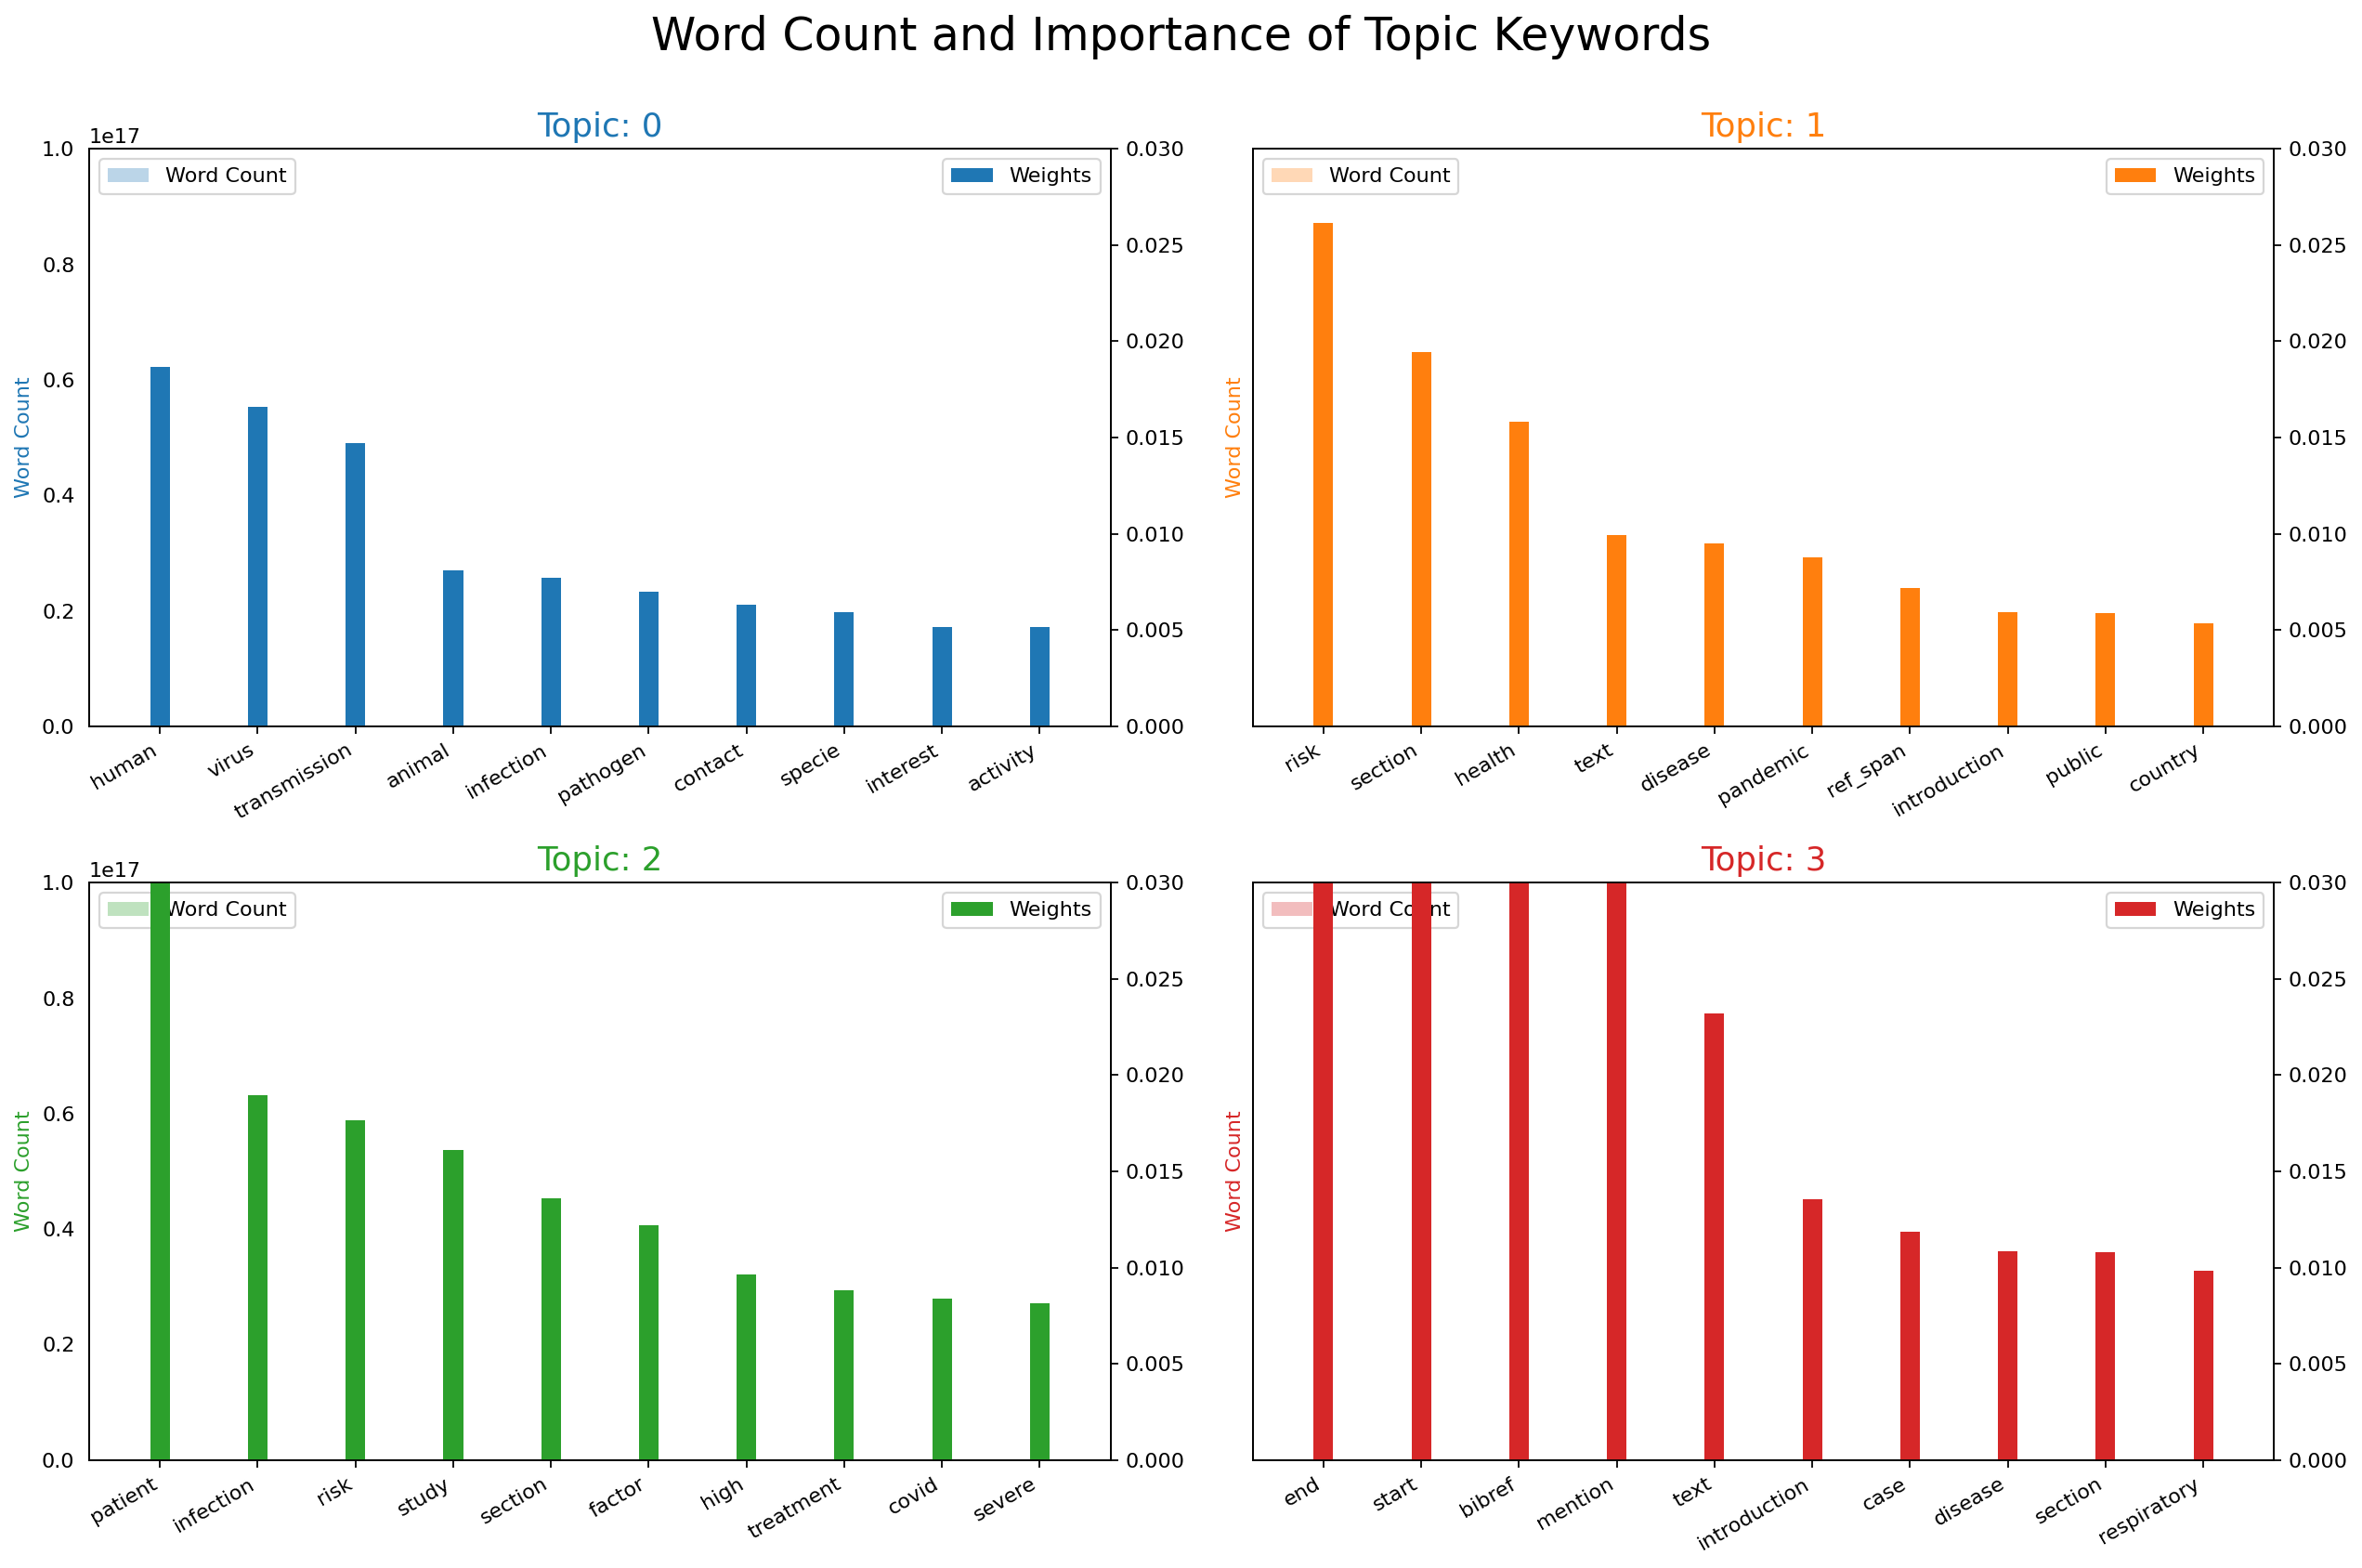

In [97]:
import matplotlib.colors as mcolors

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 100000000000000000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [98]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)



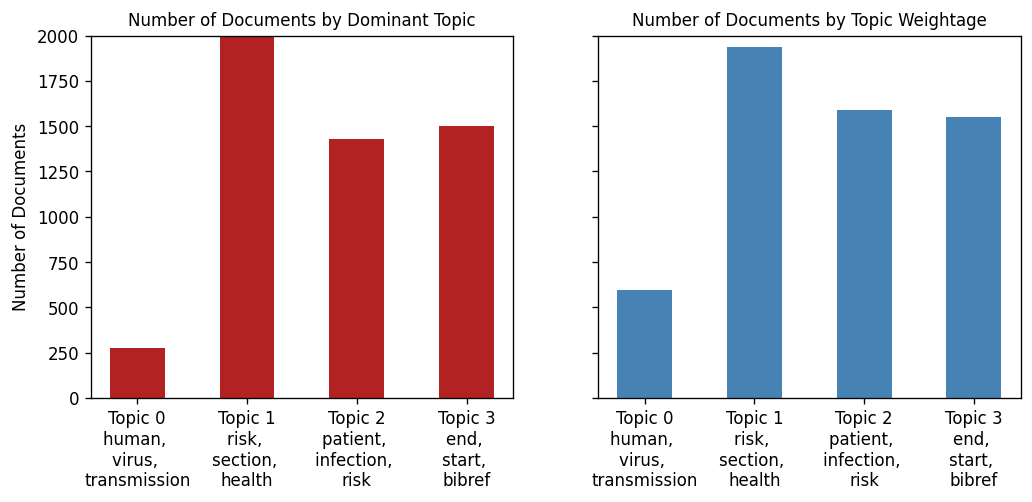

In [99]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 2000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [44]:
!pip3 install bokeh

     |████████████████████████████████| 19.3 MB 63 kB/s  eta 0:00:01
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257189 sha256=28975997b5d25041312d6f005a77880de7a9de68cd30cc91b05527865cb83114
  Stored in directory: /home/bhavinchennur/.cache/pip/wheels/6f/1b/bc/5add06a501c46e8aee615a089555beffdad8030aa5d6d35830
Successfully built bokeh


In [100]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5051 samples in 0.085s...
[t-SNE] Computed neighbors for 5051 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5051
[t-SNE] Computed conditional probabilities for sample 2000 / 5051
[t-SNE] Computed conditional probabilities for sample 3000 / 5051
[t-SNE] Computed conditional probabilities for sample 4000 / 5051
[t-SNE] Computed conditional probabilities for sample 5000 / 5051
[t-SNE] Computed conditional probabilities for sample 5051 / 5051
[t-SNE] Mean sigma: 0.030530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.378670
[t-SNE] KL divergence after 1000 iterations: 0.826917


Loading BokehJS ...